In [186]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#**Прогностическая модель рисков беременных**






##**Описание проекта**

**Цель проекта:** Разработка прогностической модели рисков беременных.


**Описание данных**.

**Age**         - возраст беременной женщины,  
**SystolicBP**  - верхнее значение артериального давления в
                   мм рт.ст.,  
**DiastolicBP**  - нижнее значение артериального давления в  
                   мм рт.ст.,   
**BS**          - концентрация глюкозы в крови в мМоль/л,   
**BodyTemp**    - температура тела в °F,  
**HeartRate**   - пульс в состоянии покоя в уд/мин,  

Предсказываемое значение:

**Risk Level**  - уровень риска.  
параметр **Risk Level** принимает 3 значения:   
    **high risk** - высокий риск   
    **mid risk**  - средний риск   
    **low risk**  - низкий риск   

В данном проекте стоит задача многоклассовой классификации.

В качестве метрики модели возьмем F1.


##**1.Импорт библиотек**


In [187]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

##**2. Загрузка датасета**

In [188]:
data = pd.read_csv('/content/gdrive/MyDrive/Maternal Health Risk Data Set.csv')

##**3. Анализ данных**

Выведем информацию о датасете:

In [189]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [190]:
data.head(n=10)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.00,98.0,86,high risk
1,35,140,90,13.00,98.0,70,high risk
2,29,90,70,8.00,100.0,80,high risk
3,30,140,85,7.00,98.0,70,high risk
4,35,120,60,6.10,98.0,76,low risk
5,23,140,80,7.01,98.0,70,high risk
6,23,130,70,7.01,98.0,78,mid risk
7,35,85,60,11.00,102.0,86,high risk
8,32,120,90,6.90,98.0,70,mid risk
9,42,130,80,18.00,98.0,70,high risk


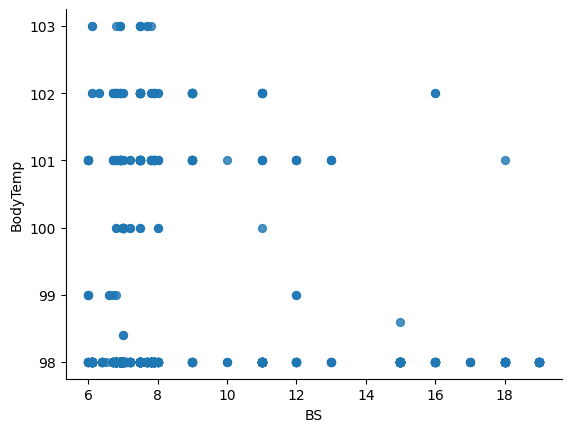

In [191]:
# @title BS vs BodyTemp

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='BS', y='BodyTemp', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

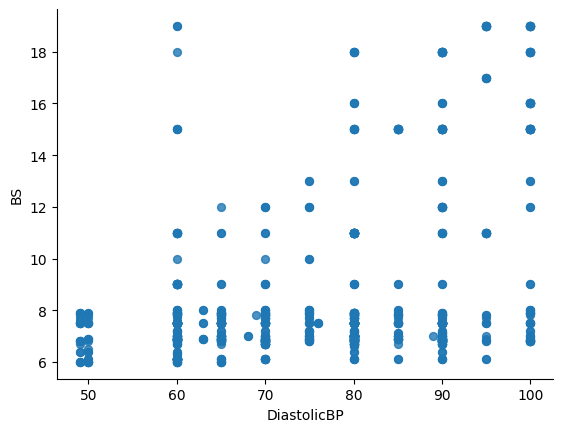

In [192]:
# @title DiastolicBP vs BS

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='DiastolicBP', y='BS', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

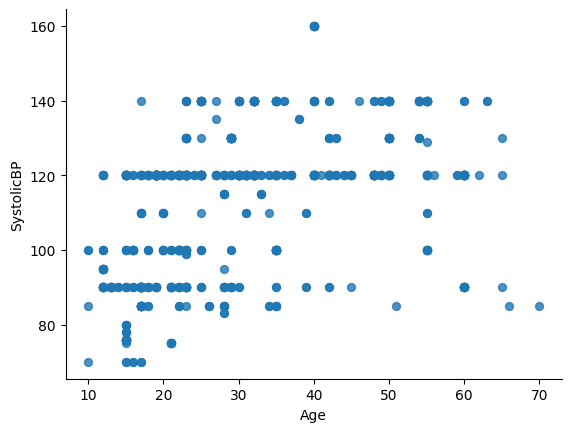

In [193]:
# @title Age vs SystolicBP

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='Age', y='SystolicBP', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

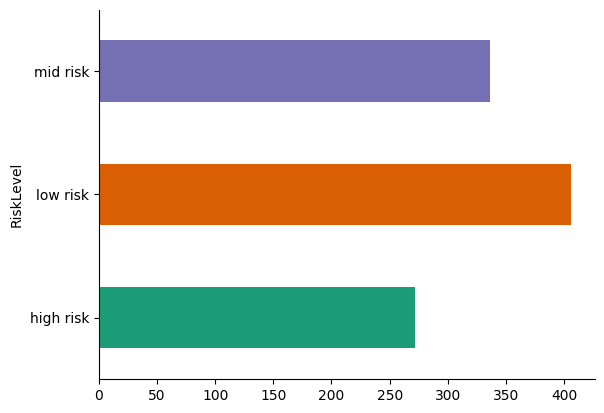

In [194]:
# @title RiskLevel
data.groupby('RiskLevel').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Оценим наличие полных дубликатов строк в датасете:

In [195]:
data.duplicated().sum()

562

In [196]:
data_dupl = data[data.duplicated()== True]
data_dupl.sort_values(by='BS', ascending=False).head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
603,55,140,95,19.0,98.0,77,high risk
137,55,140,95,19.0,98.0,77,high risk
1011,35,85,60,19.0,98.0,86,high risk
994,40,160,100,19.0,98.0,77,high risk
262,40,160,100,19.0,98.0,77,high risk


In [197]:
data.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


В данных присутствуют строки с идентичными значениями всех признаков, так как в данных нет уникального номера пациента,а представленные признаки вполне могут быть одинаковыми у различных людей, поэтому оставим эти строки в датасете.

Размер датасета составляет 1014 строк на 7 столбцов. Данные не содержат пропущенных значений, тип данных соответствует содержимой информации. Имеется небольшой дисбаланс классов.

Теперь посмотрим на значения каждого признака более внимательно

Какие значения принимает параметр "Age":

<ipython-input-198-76d6bb11018a>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


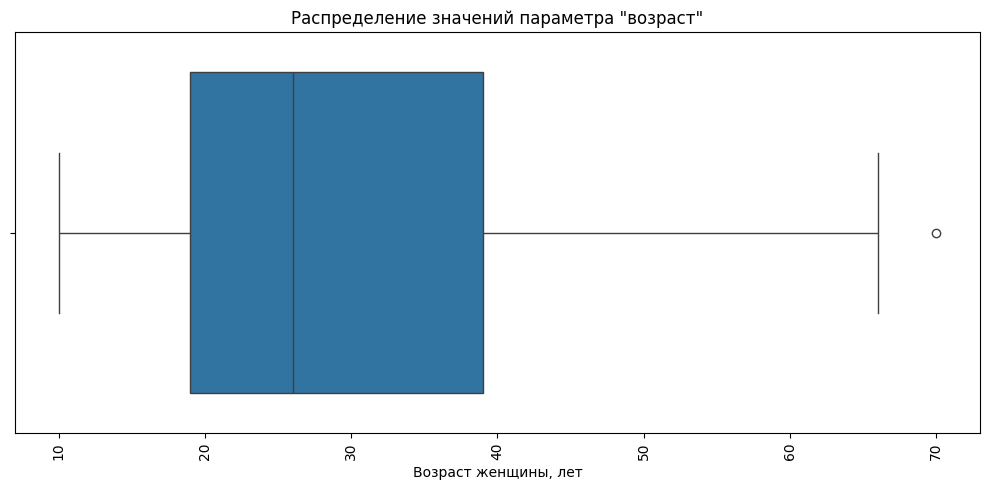

In [198]:
plt.figure(figsize=(10,5));
ax = sns.boxplot(data['Age'],orient = 'h');
ax.set_title ('Распределение значений параметра "возраст"');
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_xlabel('Возраст женщины, лет');
plt.tight_layout();

<Axes: >

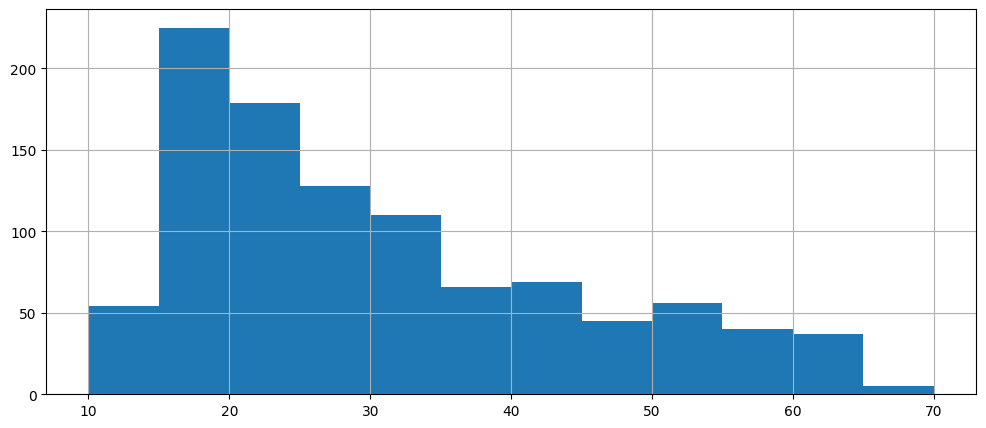

In [199]:

data['Age'].hist(bins = 12, figsize = (12,5))


По гистограмме видно, что выборка имеет нормальное распределение,  со  смещением вправо и имеет относительно длинный хвост справа. Медианный возрас находится в районе 26 лет, интерквантильный размах от 19 лет до 40 лет, что вполне вписывается в возраст фертильности.

На представленных графиках видно,что есть значения возрастов, в которых беременность либо маловероятна, либо невозможна. Диапазон возраста фертильности у женщин с 12 до 45 лет, поэтому посмотрим сколько значений находится вне этого диапазона:

In [200]:
data_to_young = data.loc[(data['Age']< 12)]
data_to_young.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 19 to 849
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          4 non-null      int64  
 1   SystolicBP   4 non-null      int64  
 2   DiastolicBP  4 non-null      int64  
 3   BS           4 non-null      float64
 4   BodyTemp     4 non-null      float64
 5   HeartRate    4 non-null      int64  
 6   RiskLevel    4 non-null      object 
dtypes: float64(2), int64(4), object(1)
memory usage: 256.0+ bytes


Посмотрим на отфильтрованные значения

In [201]:
data_to_young.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
19,10,70,50,6.9,98.0,70,low risk
250,10,85,65,6.9,98.0,70,low risk
670,10,100,50,6.0,99.0,70,mid risk
849,10,100,50,6.0,99.0,70,mid risk


In [202]:
data_to_old = data.loc[(data['Age']>55)]
data_to_old.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, 36 to 1001
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          45 non-null     int64  
 1   SystolicBP   45 non-null     int64  
 2   DiastolicBP  45 non-null     int64  
 3   BS           45 non-null     float64
 4   BodyTemp     45 non-null     float64
 5   HeartRate    45 non-null     int64  
 6   RiskLevel    45 non-null     object 
dtypes: float64(2), int64(4), object(1)
memory usage: 2.8+ KB


In [203]:
data_to_old.sort_values('Age',ascending=False).head(10)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
338,70,85,60,6.9,102.0,70,low risk
326,66,85,60,6.9,98.0,86,low risk
322,65,90,60,6.9,98.0,70,low risk
339,65,120,90,6.9,103.0,76,low risk
435,65,130,80,15.0,98.0,86,high risk
502,63,140,90,15.0,98.0,90,high risk
114,63,140,90,15.0,98.0,90,high risk
313,62,120,80,6.9,98.0,66,low risk
515,60,90,65,7.5,98.0,77,low risk
553,60,120,85,15.0,98.0,60,mid risk


Очень хочется удалить информацию о 70-летней маме, так как она, в любом случае попала в зону выброса. В идеале можно было стратифицировать выборку по возрасту фертильности и всех значений которые лежат вне его. Обсудила бы этот вопрос с поставщиком данных, здесь такой возможности не имею, выборка маленькая и так, попробую оставить все, кроме 70-ти лет.

In [204]:
data_filter_age = data[data['Age']<70]
data_filter_age.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1013 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1013 non-null   int64  
 1   SystolicBP   1013 non-null   int64  
 2   DiastolicBP  1013 non-null   int64  
 3   BS           1013 non-null   float64
 4   BodyTemp     1013 non-null   float64
 5   HeartRate    1013 non-null   int64  
 6   RiskLevel    1013 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 63.3+ KB


все верно, удалилось 1 значение.

Теперь посмотрим на параметр "SystolicBP"

<ipython-input-205-8552b337adf1>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


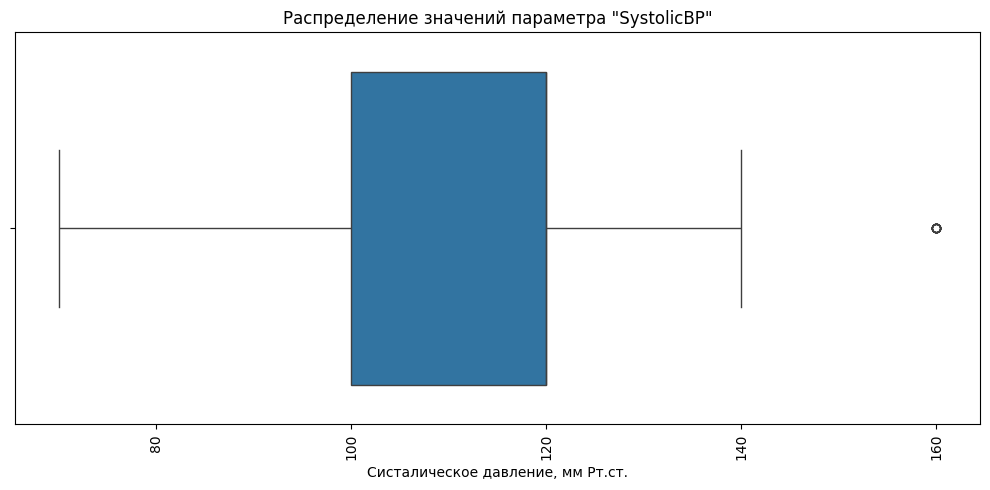

In [205]:
plt.figure(figsize=(10,5));
ax = sns.boxplot(data_filter_age['SystolicBP'],orient = 'h');
ax.set_title ('Распределение значений параметра "SystolicBP"');
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_xlabel('Систалическое давление, мм Рт.ст.');
plt.tight_layout();

Медианное значение составляет 120 мм Рт. ст., интерквантильный размах от 100 до 120 мм Рт.ст. Есть значения в 70 мм Рт.ст..

In [206]:
data_filter_sys = data_filter_age[data_filter_age['SystolicBP']>140]
data_filter_sys.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 123 to 994
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          10 non-null     int64  
 1   SystolicBP   10 non-null     int64  
 2   DiastolicBP  10 non-null     int64  
 3   BS           10 non-null     float64
 4   BodyTemp     10 non-null     float64
 5   HeartRate    10 non-null     int64  
 6   RiskLevel    10 non-null     object 
dtypes: float64(2), int64(4), object(1)
memory usage: 640.0+ bytes


Посмотрим на странные 10 значений:

In [207]:
data_filter_sys.head(10)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
123,40,160,100,19.0,98.0,77,high risk
130,40,160,100,19.0,98.0,77,high risk
166,40,160,100,19.0,98.0,77,high risk
262,40,160,100,19.0,98.0,77,high risk
362,40,160,100,19.0,98.0,77,high risk
538,40,160,100,19.0,98.0,77,high risk
583,40,160,100,19.0,98.0,77,high risk
689,40,160,100,19.0,98.0,77,high risk
961,40,160,100,19.0,98.0,77,high risk
994,40,160,100,19.0,98.0,77,high risk


Задублированные строки со значением в зоне выброса-можно удалить.

In [208]:
data_filter_sys = data_filter_age[data_filter_age['SystolicBP']<=140]
data_filter_sys.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1003 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1003 non-null   int64  
 1   SystolicBP   1003 non-null   int64  
 2   DiastolicBP  1003 non-null   int64  
 3   BS           1003 non-null   float64
 4   BodyTemp     1003 non-null   float64
 5   HeartRate    1003 non-null   int64  
 6   RiskLevel    1003 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 62.7+ KB


Теперь посмотрим на параметр "DiastolicBP"

<ipython-input-209-62554ce16a2c>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


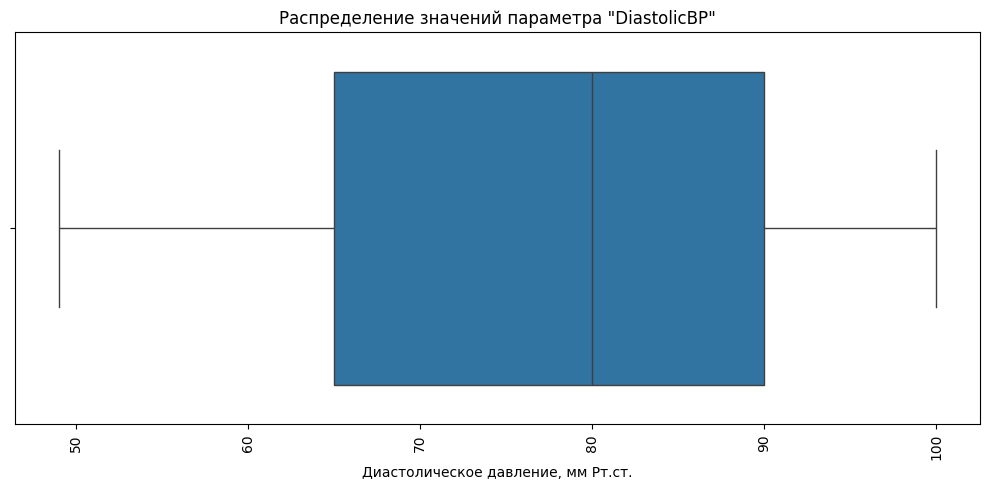

In [209]:
plt.figure(figsize=(10,5));
ax = sns.boxplot(data_filter_sys['DiastolicBP'],orient = 'h');
ax.set_title ('Распределение значений параметра "DiastolicBP"');
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_xlabel('Диастолическое давление, мм Рт.ст.');
plt.tight_layout();

Медианное значение составляет 80 мм Рт. ст., интерквантильный размах от 65 до 90 мм Рт.ст. Выбросов нет.

Теперь посмотрим на параметр "BS", это концентрация глюкозы в крови в мМоль/л


<ipython-input-210-125a736ba046>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


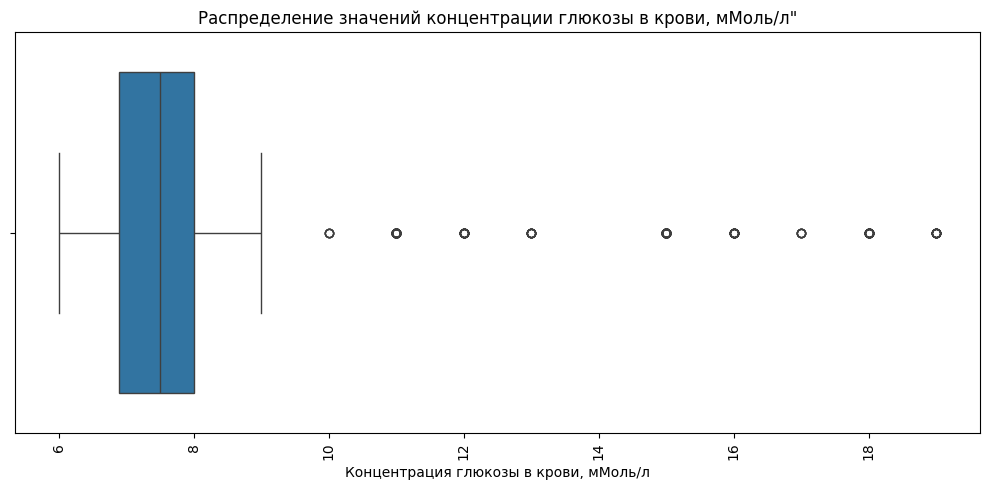

In [210]:
plt.figure(figsize=(10,5));
ax = sns.boxplot(data_filter_sys['BS'],orient = 'h');
ax.set_title ('Распределение значений концентрации глюкозы в крови, мМоль/л"');
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_xlabel('Концентрация глюкозы в крови, мМоль/л');
plt.tight_layout();

Медианное значение составляет 7,5 мМоль/л, интерквантильный размах от 6,9 мМоль/л до 8 мМоль/л. Есть выбросы в зоне значений высоких концентраций глюкозы. Если ориентироваться на референсные значения концентрации глюкозы "на тощак", то это < 5,1 ММоль/л, то можно предположить, что вся представленная выборка беременных женщин, это женщины с диабетом или это значения глюкозы при проведении глюкозо-толерантного теста.

Посмотрим на экстримальные значения концентрации глюкозы в крови в представленном датасете:

In [211]:
data_filter_BS = data_filter_sys[data_filter_sys['BS']>14]
data_filter_BS.head(15)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
9,42,130,80,18.0,98.0,70,high risk
16,50,140,90,15.0,98.0,90,high risk
20,40,140,100,18.0,98.0,90,high risk
74,44,120,90,16.0,98.0,80,mid risk
91,60,120,85,15.0,98.0,60,mid risk
102,48,140,90,15.0,98.0,90,high risk
106,50,140,90,15.0,98.0,90,high risk
108,42,140,100,18.0,98.0,90,high risk
110,50,140,95,17.0,98.0,60,high risk


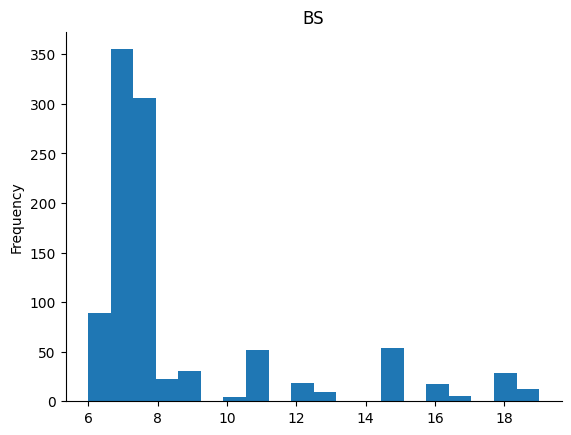

In [212]:
# @title BS
data_filter_sys['BS'].plot(kind='hist', bins=20, title='BS')
plt.gca().spines[['top', 'right',]].set_visible(False)

Ничего не удаляем пока.

Теперь посмотрим на параметр "BodyTemp", это температура тела  в °F

<ipython-input-213-c6e0fee0d62d>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


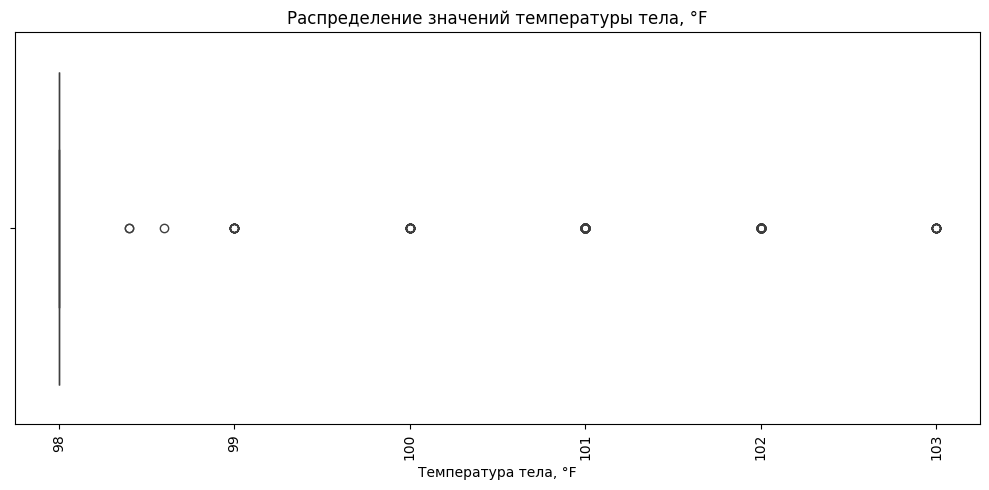

In [213]:
plt.figure(figsize=(10,5));
ax = sns.boxplot(data_filter_sys['BodyTemp'],orient = 'h');
ax.set_title ('Распределение значений температуры тела, °F');
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_xlabel('Температура тела, °F');
plt.tight_layout();

In [214]:
data_filter_temp = data_filter_sys[data_filter_sys['BodyTemp']>98]
data_filter_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209 entries, 2 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          209 non-null    int64  
 1   SystolicBP   209 non-null    int64  
 2   DiastolicBP  209 non-null    int64  
 3   BS           209 non-null    float64
 4   BodyTemp     209 non-null    float64
 5   HeartRate    209 non-null    int64  
 6   RiskLevel    209 non-null    object 
dtypes: float64(2), int64(4), object(1)
memory usage: 13.1+ KB


Основная масса значений температуры тела в датасете составляет 98 °F (36,6°С), есть 209 значений превышающих нормальную температуру тела, но все значения вполне адекватны. Пока удалять не будем.

Теперь посмотрим на параметр "HeartRate", это частота сердечных сокращений, выраженная в уд/мин

<ipython-input-215-b6e1070c7ef0>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


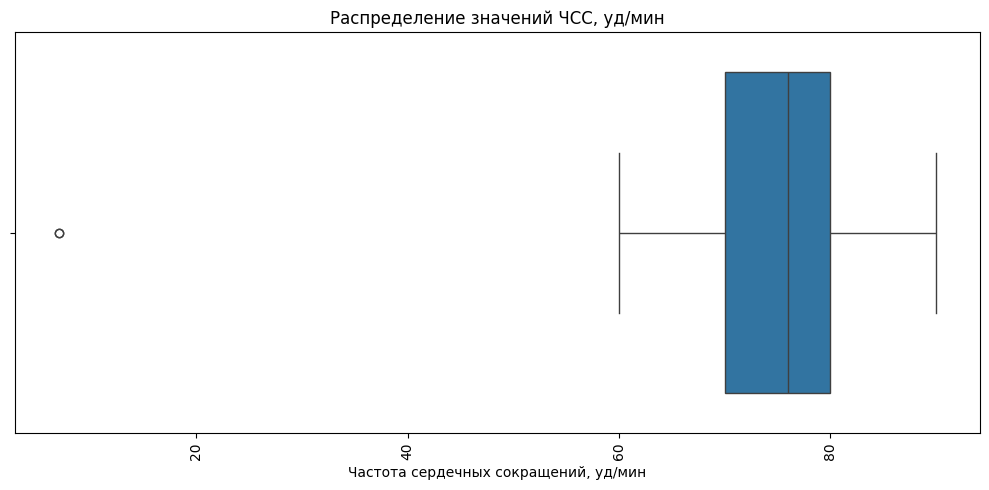

In [215]:
plt.figure(figsize=(10,5));
ax = sns.boxplot(data_filter_sys['HeartRate'],orient = 'h');
ax.set_title ('Распределение значений ЧСС, уд/мин');
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_xlabel('Частота сердечных сокращений, уд/мин');
plt.tight_layout();

Медианное значение признака составляет 76 уд/мин, интерквантильный размах 70-80 уд/мин. Посмотрим, что попало в зону выбросов.

In [216]:
data_filter_hr = data_filter_sys[data_filter_sys['HeartRate']<60]
data_filter_hr.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
499,16,120,75,7.9,98.0,7,low risk
908,16,120,75,7.9,98.0,7,low risk


Избавимся от этого значения как не соответствующего действительности.

In [217]:
data_filter_hr = data_filter_sys[data_filter_sys['HeartRate']>7]

<ipython-input-218-6b0b40ea09fe>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


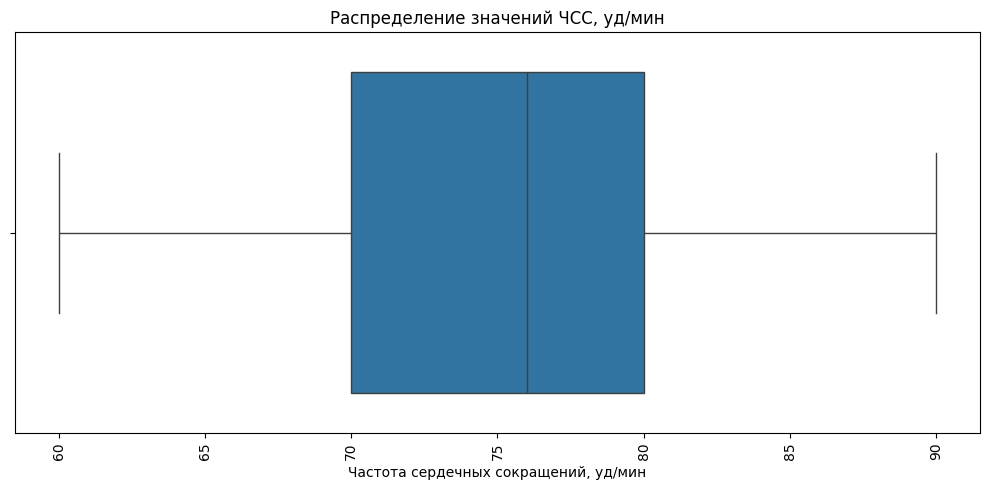

In [218]:
plt.figure(figsize=(10,5));
ax = sns.boxplot(data_filter_hr['HeartRate'],orient = 'h');
ax.set_title ('Распределение значений ЧСС, уд/мин');
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_xlabel('Частота сердечных сокращений, уд/мин');
plt.tight_layout();

ок.

##**4. Подготовка признаков**

Разделим датасет на обучающую, валидационную и тестовую выборку:

In [219]:
data_filter_hr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1001 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1001 non-null   int64  
 1   SystolicBP   1001 non-null   int64  
 2   DiastolicBP  1001 non-null   int64  
 3   BS           1001 non-null   float64
 4   BodyTemp     1001 non-null   float64
 5   HeartRate    1001 non-null   int64  
 6   RiskLevel    1001 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 62.6+ KB


In [220]:
data_train, data_val_test = train_test_split(data_filter_hr,test_size = 0.4, random_state = 12345)

In [221]:
data_train.shape

(600, 7)

In [222]:
data_val_test.shape

(401, 7)

Теперь сформируем валидационные и тестовые выборки. Тестовую спрячем до последнего этапа тестирования.

In [223]:
data_valid, data_test = train_test_split(data_val_test,test_size = 0.4, random_state = 12345)

In [224]:
data_valid.shape

(240, 7)

In [225]:
data_test.shape

(161, 7)

Все выборки разделились верно: обучающая - 600 значений, валидационная - 240 значений, тестовая - 161 значение.

Разделим признаки и таргет обучающей выборки:

In [226]:
Y_train = data_train['RiskLevel']
Y_train.info()

<class 'pandas.core.series.Series'>
Index: 600 entries, 314 to 488
Series name: RiskLevel
Non-Null Count  Dtype 
--------------  ----- 
600 non-null    object
dtypes: object(1)
memory usage: 9.4+ KB


Оценим соотношение классов в обучающей выборке:

In [227]:
class_frequency = Y_train.value_counts()

<Axes: xlabel='RiskLevel'>

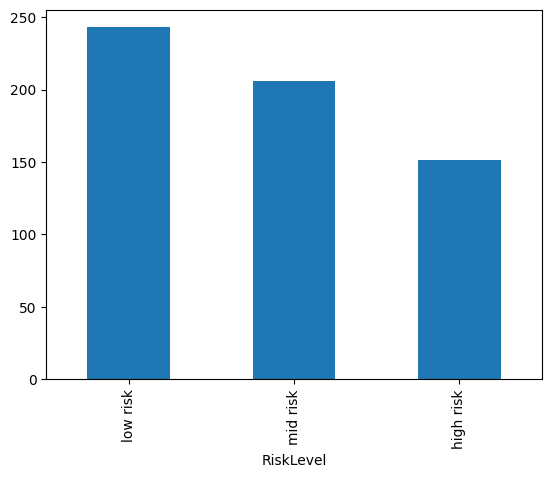

In [228]:
class_frequency.plot(kind = 'bar')

Не совсем равномерно, но и перекос не сильный.

In [229]:
X_train = data_train.drop('RiskLevel', axis=1)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 314 to 488
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          600 non-null    int64  
 1   SystolicBP   600 non-null    int64  
 2   DiastolicBP  600 non-null    int64  
 3   BS           600 non-null    float64
 4   BodyTemp     600 non-null    float64
 5   HeartRate    600 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 32.8 KB


Теперь отмасштабируем значения признаков обучающей и валидационной выборки. Значения различных параметров имеет разный порядок величин, произведем нормировку.

In [230]:
scaler = StandardScaler()

In [231]:
X_train_scaled = scaler.fit_transform(X_train)

In [232]:
X_train_scaled[0]

array([-0.33808207, -1.25175536, -0.46117283, -0.55033503, -0.51891529,
       -1.11366952])

Теперь закодируем категориальный таргет:

In [233]:
label_encoder = LabelEncoder()

In [234]:
Y_train_encoded = label_encoder.fit_transform(Y_train)

In [235]:
Y_train_encoded[0:10]

array([1, 1, 2, 1, 1, 0, 0, 2, 1, 2])

Теперь произведем те же действия с валидационной выборкой:

Разделим признаки и таргет валидационной выборки:

In [236]:
Y_valid = data_valid['RiskLevel']
Y_valid.info()

<class 'pandas.core.series.Series'>
Index: 240 entries, 675 to 535
Series name: RiskLevel
Non-Null Count  Dtype 
--------------  ----- 
240 non-null    object
dtypes: object(1)
memory usage: 3.8+ KB


In [237]:
X_valid = data_valid.drop('RiskLevel', axis=1)
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 675 to 535
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          240 non-null    int64  
 1   SystolicBP   240 non-null    int64  
 2   DiastolicBP  240 non-null    int64  
 3   BS           240 non-null    float64
 4   BodyTemp     240 non-null    float64
 5   HeartRate    240 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 13.1 KB


In [238]:
scaler = StandardScaler()

In [239]:
X_valid_scaled = scaler.fit_transform(X_valid)

In [240]:
X_valid_scaled[0]

array([ 0.35545927,  1.52147731,  0.98482797,  1.40767077, -0.41718876,
       -0.65099122])

Теперь закодируем категориальный таргет:

In [241]:
label_encoder = LabelEncoder()

In [242]:
Y_valid_encoded = label_encoder.fit_transform(Y_valid)

In [243]:
Y_valid_encoded[0:10]

array([0, 1, 1, 1, 2, 1, 1, 2, 1, 1])

##**5.Обучение модели**

В качестве моделей для решения задачи многоклассовой классификации возьмем модели решающего дерева и случайного леса, как наиболее интерпретируемые.

###*5.1. Модель решающего дерева (все настройки "по умолчанию")*

In [244]:
model = DecisionTreeClassifier(random_state = 12345)

обучаем модель на тренировочном датасете:

In [245]:
model.fit(X_train_scaled, Y_train_encoded)

DecisionTreeClassifier(random_state=12345)

In [246]:
predicted_valid = model.predict(X_valid_scaled)

In [247]:
f1_sc = f1_score(Y_valid_encoded,predicted_valid, average = "macro")
print("Метрика F1:",f1_sc)

Метрика F1: 0.7977138602314464


In [248]:
cm = confusion_matrix(Y_valid_encoded,predicted_valid, labels=[0, 1, 2])
print(cm)

[[53  2 11]
 [ 2 77 17]
 [ 6 11 61]]


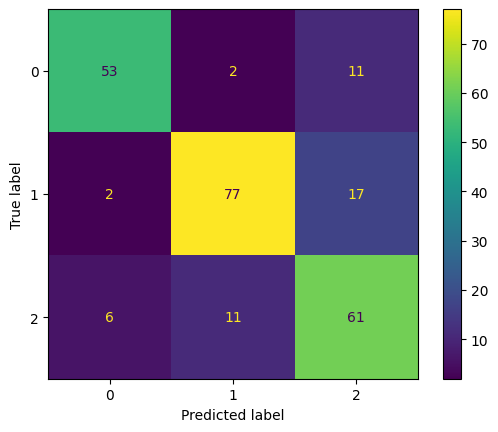

In [249]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1, 2])
disp.plot()
plt.show()

Значение меток: 0 - 'high risk', 1 - 'low risk', 2 - 'mid risk'

In [250]:
target_names = ['high risk', 'low risk', 'mid risk']
print(classification_report(Y_valid_encoded,predicted_valid, target_names=target_names))

              precision    recall  f1-score   support

   high risk       0.87      0.80      0.83        66
    low risk       0.86      0.80      0.83        96
    mid risk       0.69      0.78      0.73        78

    accuracy                           0.80       240
   macro avg       0.80      0.80      0.80       240
weighted avg       0.80      0.80      0.80       240



По полученным значениям precision, recall и f1-score модель хорошо справилась с классификацией высоких и низких рисков беременных с диагностированным сахарным диабетом, чуть хуже обстоят дела с выявлением средних рисков, здесь метрика F1 на 0,1 ниже чем F1 для высоких и низких рисков.

Теперь посмотрим ансамблевый метод случайного леса:

###*5.2. Модель случайного леса (все настройки "по умолчанию")*

In [251]:
model_RF = RandomForestClassifier(random_state=12345)

обучаем модель на тренировочном датасете:

In [252]:
model_RF.fit(X_train_scaled, Y_train_encoded)

RandomForestClassifier(random_state=12345)

In [253]:
predicted_valid_rf = model_RF.predict(X_valid_scaled)

In [254]:
f1_sc = f1_score(Y_valid_encoded,predicted_valid_rf, average = "macro")
print("Метрика F1:",f1_sc)

Метрика F1: 0.870507525882844


In [255]:
cm_rf = confusion_matrix(Y_valid_encoded,predicted_valid_rf, labels=[0, 1, 2])
print(cm_rf)

[[61  1  4]
 [ 1 82 13]
 [ 3 10 65]]


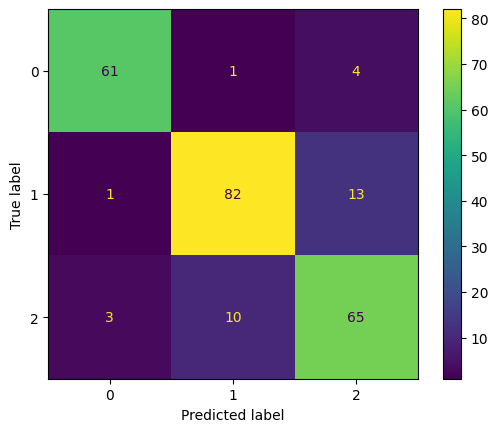

In [256]:
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                              display_labels=[0, 1, 2])
disp_rf.plot()
plt.show()

Значение меток: 0 - 'high risk', 1 - 'low risk', 2 - 'mid risk'

In [257]:
target_names = ['high risk', 'low risk', 'mid risk']
print(classification_report(Y_valid_encoded,predicted_valid_rf, target_names=target_names))

              precision    recall  f1-score   support

   high risk       0.94      0.92      0.93        66
    low risk       0.88      0.85      0.87        96
    mid risk       0.79      0.83      0.81        78

    accuracy                           0.87       240
   macro avg       0.87      0.87      0.87       240
weighted avg       0.87      0.87      0.87       240



Как и ожидалось на ансамблевом методе метрика F1 для всех классов подросла, но теперь модель лучше справляется с определением высокого риска, чуть хуже с низким риском, на третьем месте средний риск.

Из 2-х моделей для тестирования выберем модель случайного леса, как показавшую лучшие значения метрики F1.

##**6. Тестирование модели**

###**6.1. Подготовка тестовой выборки**

Разделим признаки и таргет тестовой выборки:

In [258]:
Y_test = data_test['RiskLevel']
Y_test.info()

<class 'pandas.core.series.Series'>
Index: 161 entries, 894 to 111
Series name: RiskLevel
Non-Null Count  Dtype 
--------------  ----- 
161 non-null    object
dtypes: object(1)
memory usage: 2.5+ KB


In [259]:
X_test = data_test.drop('RiskLevel', axis=1)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161 entries, 894 to 111
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          161 non-null    int64  
 1   SystolicBP   161 non-null    int64  
 2   DiastolicBP  161 non-null    int64  
 3   BS           161 non-null    float64
 4   BodyTemp     161 non-null    float64
 5   HeartRate    161 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 8.8 KB


Теперь отмасштабируем значения признаков тестовой выборки. Значения различных параметров имеет разный порядок величин, произведем нормировку.

In [260]:
scaler = StandardScaler()

In [261]:
X_test_scaled = scaler.fit_transform(X_test)

In [262]:
X_test_scaled[0]

array([-0.83167553,  0.28822004, -0.04050626, -0.25528228, -0.47263392,
       -0.5038068 ])

Теперь закодируем категориальный таргет:

In [263]:
label_encoder = LabelEncoder()

In [264]:
Y_test_encoded = label_encoder.fit_transform(Y_test)

In [265]:
Y_test_encoded[0:10]

array([1, 2, 0, 2, 0, 0, 0, 1, 0, 1])

In [266]:
#model_RF = RandomForestClassifier(random_state=12345)

In [267]:
predicted_test_rf = model_RF.predict(X_test_scaled)

In [268]:
f1_sc = f1_score(Y_test_encoded,predicted_test_rf, average = "macro")
print("Метрика F1:",f1_sc)

Метрика F1: 0.803604112833764


In [269]:
cm_rf = confusion_matrix(Y_test_encoded,predicted_test_rf, labels=[0, 1, 2])
print(cm_rf)

[[37  2  6]
 [ 0 53 11]
 [ 4  9 39]]


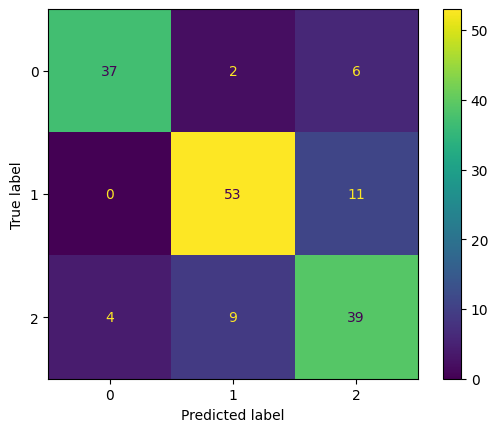

In [270]:
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                              display_labels=[0, 1, 2])
disp_rf.plot()
plt.show()

Значение меток: 0 - 'high risk', 1 - 'low risk', 2 - 'mid risk'

In [271]:
target_names = ['high risk', 'low risk', 'mid risk']
print(classification_report(Y_test_encoded,predicted_test_rf, target_names=target_names))

              precision    recall  f1-score   support

   high risk       0.90      0.82      0.86        45
    low risk       0.83      0.83      0.83        64
    mid risk       0.70      0.75      0.72        52

    accuracy                           0.80       161
   macro avg       0.81      0.80      0.80       161
weighted avg       0.81      0.80      0.80       161



##**7. Отчет**

В настоящем проекте решалась задача по построению  прогностической модели рисков беременных.
Для работы был предоставлен датасет, содержащий 1014 значений 6-ти параметров:  
**Описание данных**.

**Age**         - возраст беременной женщины,  
**SystolicBP**  - верхнее значение артериального давления в
                   мм рт.ст.,  
**DiastolicBP**  - нижнее значение артериального давления в  
                   мм рт.ст.,   
**BS**          - концентрация глюкозы в крови в мМоль/л,   
**BodyTemp**    - температура тела в °F,  
**HeartRate**   - пульс в состоянии покоя в уд/мин,  

Предсказываемое значение:

**Risk Level**  - уровень риска.  
параметр **Risk Level** принимает 3 значения:   
    **high risk** - высокий риск   
    **mid risk**  - средний риск   
    **low risk**  - низкий риск   

В данном проекте стоит задача многоклассовой классификации.

В качестве метрики модели возьмем F1 и построим матрицу ошибок для оценки качества модели.

**Оценка датасета**  
    1. Пропущенные значения отсутствуют,     
    2. Есть задублированные строки, но удалить их все не решилась, так как нет уникального номера пациента, а значения признаков могут быть похожи у различных пациентов,  
    3. Имеется небольшой дисбаланс классов  
    4. В ходе предобработки данных было удалено 1 выброс это мама в возрасте 70 лет (хотелось и остальных с 60 до 70 лет, но без экспертной оценки не стала) и 10 дублированных строк с выбросом по систалическому давлению в 160 мм Hg ст. Выбросы по остальным параметрам трогать не стала без экспертной оценки.  

**Выбор модели**  
В качестве моделей были выбраны модель решающего дерева(DecisionTreeClassifier) и случайного леса(RandomForestClassifier), подходящие под задачи многоклассовой классификации и как наиболее простые и интерпретируемые. Все модели были взяты "из коробки" с настроенными гиперпараметрами "по умолчанию".  

**Подготовка признаков**  
Так как различные признаки имеют отличающиеся на несколько порядков абсолютные значения, было проведено масштабирование признаков и кодирование категориального целевого (предсказываемого) признака.
 Весь датасет был разделен на 3 выборки: обучающую, валидационную и тестовую (обучающая - 600 значений, валидационная - 240 значений, тестовая - 161 значение).  

 **Выбор модели**  
 Критерием качества модели было более высокое значение метрики **F1** на валидационной выборке.  

 Метрика F1 не имеет размерности (принимаетзначения от 0 до 1) и отражает среднее гармоническое между метрикой, отражающей долю правильно предсказанных классов риска от всех предсказаний этого класса (**Precision**) и метрикой, отражающей долю правильно предсказанных классов риска к суммарному истинному количеству этого класса в выборке (**Recall**).

 Дополнительно были построены матрицы ошибок для каждой модели на стадии выбора и тестирования.  

Так как метрика не была задана заказчиком, минимальное значение метрики было взято от 0,7.

В качестве лучшей модели была выбрана модель случайного леса (RandomForestClassifier) с настройками гиперпараметров "по умолчанию"
на которой была получена метрика F1 = 0.87.   

**Заключение** Полученная модель хорошо справляется с классификацией рисков, особенно высокого и низкого уровня, чуть больше ошибок в среднем риске, но это можно объяснить переходным состоянием от низкого к высокому, в котором часть признаков еще находится в низкой зоне риска, а часть уже приближается к зоне высокого риска.

**Рекоммендации**  Можно попробовать разделить пациентов на страты по возрасту, так как с ростом возраста пациента увеличивается количество сопутствующих хронических заболеваний, автоматически повышающих риск развития патологических состояний.

**Модель RandomForestClassifier на валидационной выборке:**

In [272]:
f1_sc = f1_score(Y_valid_encoded,predicted_valid_rf, average = "macro")
print("Метрика F1:",f1_sc)

Метрика F1: 0.870507525882844


In [273]:
cm_rf = confusion_matrix(Y_valid_encoded,predicted_valid_rf, labels=[0, 1, 2])
print(cm_rf)

[[61  1  4]
 [ 1 82 13]
 [ 3 10 65]]


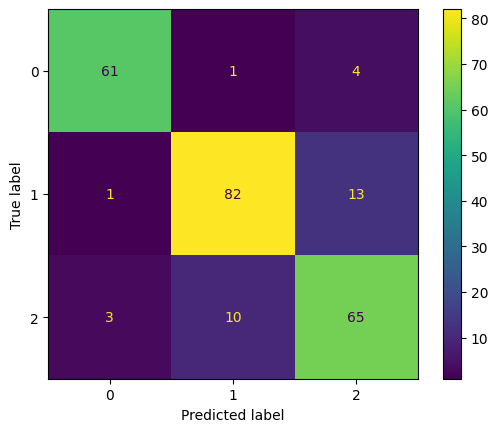

In [274]:
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                              display_labels=[0, 1, 2])
disp_rf.plot()
plt.show()

Значение меток: 0 - 'high risk', 1 - 'low risk', 2 - 'mid risk'

In [275]:
target_names = ['high risk', 'low risk', 'mid risk']
print(classification_report(Y_valid_encoded,predicted_valid_rf, target_names=target_names))

              precision    recall  f1-score   support

   high risk       0.94      0.92      0.93        66
    low risk       0.88      0.85      0.87        96
    mid risk       0.79      0.83      0.81        78

    accuracy                           0.87       240
   macro avg       0.87      0.87      0.87       240
weighted avg       0.87      0.87      0.87       240



**Модель RandomForestClassifier на тестовой выборке:**

In [276]:
f1_sc = f1_score(Y_test_encoded,predicted_test_rf, average = "macro")
print("Метрика F1:",f1_sc)

Метрика F1: 0.803604112833764


In [277]:
cm_rf = confusion_matrix(Y_test_encoded,predicted_test_rf, labels=[0, 1, 2])
print(cm_rf)

[[37  2  6]
 [ 0 53 11]
 [ 4  9 39]]


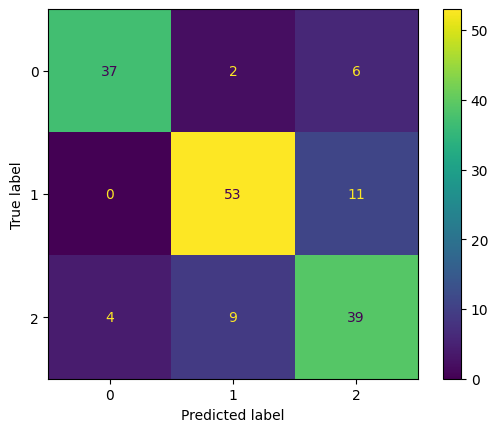

In [278]:
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                              display_labels=[0, 1, 2])
disp_rf.plot()
plt.show()

Значение меток: 0 - 'high risk', 1 - 'low risk', 2 - 'mid risk'

In [279]:
target_names = ['high risk', 'low risk', 'mid risk']
print(classification_report(Y_test_encoded,predicted_test_rf, target_names=target_names))

              precision    recall  f1-score   support

   high risk       0.90      0.82      0.86        45
    low risk       0.83      0.83      0.83        64
    mid risk       0.70      0.75      0.72        52

    accuracy                           0.80       161
   macro avg       0.81      0.80      0.80       161
weighted avg       0.81      0.80      0.80       161

